In [37]:
import numpy as np
import pandas as pd
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
%matplotlib notebook

In [22]:
df_full = pd.read_csv('train_2v.csv')
df_full.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status        True
stroke               False
dtype: bool

In [23]:
non_num_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
df_full = pd.get_dummies(df_full, columns=non_num_cols)

In [24]:
redundant_cols = ["ever_married_No", "Residence_type_Rural"]
df_full = df_full.drop(columns=redundant_cols)

In [25]:
df_full.columns.tolist()

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke',
 'gender_Female',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Govt_job',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [26]:
seed = 10000

df_train, df_test = train_test_split(df_full, test_size=0.1, stratify=df_full['stroke'], random_state=seed)

y_train = df_train["stroke"]
x_train = df_train.drop(columns="stroke")

y_test = df_test["stroke"]
x_test = df_test.drop(columns="stroke")

lgbm_train = lgbm.Dataset(x_train, y_train)
lgbm_test = lgbm.Dataset(x_test, y_test, reference=lgbm_train)

In [27]:
def neg_to_pos_ratio(df):
    val_counts = df['stroke'].value_counts()
    return val_counts[0]/val_counts[1]

In [28]:
ratio = neg_to_pos_ratio(df_train)
ratio

54.40425531914894

In [29]:
neg_to_pos_ratio(df_test)

54.64102564102564

In [30]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric':'auc',
    'learning_rate': 0.0001,
    'num_leaves': 31,  
    'max_depth': -1,  
    'max_bin': 255,  
    'subsample': 0.6,  
    'colsample_bytree': 0.3,  
    'min_child_weight': 5, 
    'subsample_for_bin': 200000,  
    'min_split_gain': 0,  
    'nthread': 8,
    'verbose': 0,
    'num_iterations': 1000,
    'scale_pos_weight': ratio
}

In [31]:
cv = lgbm.cv(lgbm_params, lgbm_train)
np.mean(cv["auc-mean"])

C:\Users\Ross\AppData\Local\conda\conda\envs\datasci\lib\site-packages\lightgbm\engine.py:502: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


0.8484142542004472

In [32]:
df_train_main, df_eval = train_test_split(df_train, test_size=0.1, stratify=df_train['stroke'], random_state=seed)

y_train_main = df_train_main["stroke"]
x_train_main = df_train_main.drop(columns="stroke")

y_eval = df_eval["stroke"]
x_eval = df_eval.drop(columns="stroke")

lgbm_train_main = lgbm.Dataset(x_train_main, y_train_main)
lgbm_eval = lgbm.Dataset(x_eval, y_eval, reference=lgbm_train_main)

In [33]:
model = lgbm.train(lgbm_params,
                lgbm_train_main,
                num_boost_round=20,
                valid_sets=lgbm_eval,
                early_stopping_rounds=5)

model.save_model('model.txt')

[1]	valid_0's auc: 0.631556
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 0.653711
[3]	valid_0's auc: 0.685806
[4]	valid_0's auc: 0.722596
[5]	valid_0's auc: 0.735306
[6]	valid_0's auc: 0.786519
[7]	valid_0's auc: 0.781454
[8]	valid_0's auc: 0.804175
[9]	valid_0's auc: 0.812962
[10]	valid_0's auc: 0.808269
[11]	valid_0's auc: 0.81221
[12]	valid_0's auc: 0.816801
[13]	valid_0's auc: 0.812574
[14]	valid_0's auc: 0.815073
[15]	valid_0's auc: 0.816392
[16]	valid_0's auc: 0.814865
[17]	valid_0's auc: 0.814803
Early stopping, best iteration is:
[12]	valid_0's auc: 0.816801


C:\Users\Ross\AppData\Local\conda\conda\envs\datasci\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


<IPython.core.display.Javascript object>


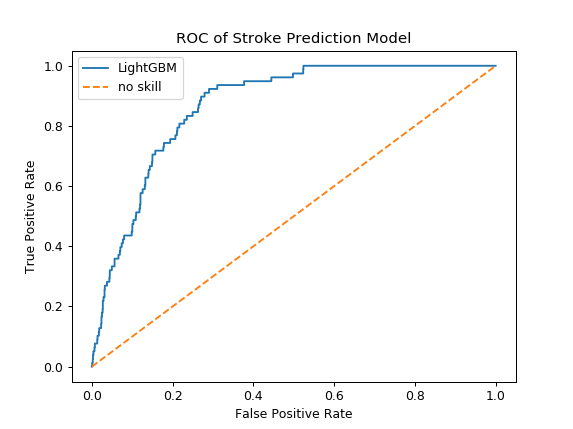

ROC-AUC Score against test_set = 0.867286


In [42]:
model_probs = model.predict(x_test)
no_skill_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, _ = roc_curve(y_test, no_skill_probs)
model_fpr, model_tpr, thresholds = roc_curve(y_test, model_probs)
plt.figure()
plt.plot(model_fpr, model_tpr, label='LightGBM')
plt.plot(ns_fpr, ns_tpr, '--', label='no skill')
plt.title("ROC of Stroke Prediction Model")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

perf = roc_auc_score(y_test, model_probs)
print("ROC-AUC Score against test_set = %f"%perf)

In [35]:
desired_tpr = 0.90

eval_probs = model.predict(x_eval)
eval_fpr, eval_tpr, thresholds = roc_curve(y_eval, eval_probs)

index = next(tpr[0] for tpr in enumerate(eval_tpr) if tpr[1] > desired_tpr)
threshold = thresholds[index]

print("For the desired true positive rate (%f) a threshold of %f is required" % (desired_tpr, threshold))

For the desired true positive rate (0.900000) a threshold of 0.018558 is required


<IPython.core.display.Javascript object>


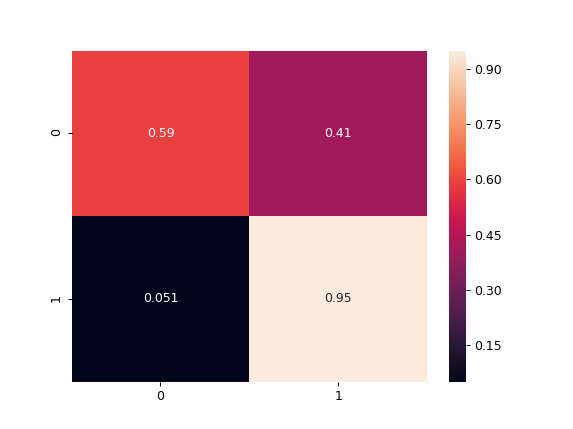

In [41]:
predicted_classifications = model_probs>threshold
conf_mat = confusion_matrix(y_test, predicted_classifications, normalize="true")
plt.figure()

sbn.heatmap(conf_mat, annot=True)